In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Field Generation

(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

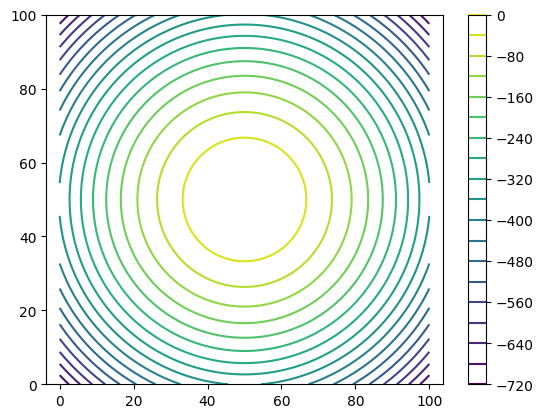

In [2]:
width=500

x_circ = np.linspace(-width // 2, width // 2, 101)  
y_circ = np.linspace(-width // 2, width // 2, 101)
X_circ, Y_circ = np.meshgrid(x_circ, y_circ)

x0_circ, y0_circ = 0, 0

A = -2/350
Psi_circ = A*( (X_circ-x0_circ)**2 + (Y_circ-y0_circ)**2 )

u_circ, v_circ = (-2*A*(Y_circ - y0_circ)).T, (2*A*(X_circ - x0_circ)).T

plt.contour(Psi_circ, 20)
plt.colorbar()
plt.axis('equal')

(np.float64(-250.0), np.float64(250.0), np.float64(-250.0), np.float64(250.0))

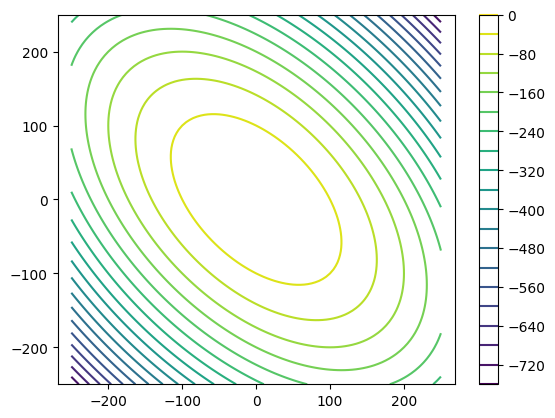

In [3]:
width=500

x_ell = np.linspace(-width // 2, width // 2, 101)  
y_ell = np.linspace(-width // 2, width // 2, 101) 
X_ell, Y_ell = np.meshgrid(x_ell, y_ell)

x0_ell, y0_ell = 0, 0

q11, q22, q12 = 2, 2, 1
A = -1/500
q11 *= A
q22 *= A
q12 *= A
Q = np.array([[q11, q12], [q12, q22]])

XY = np.stack((X_ell, Y_ell), axis=-1)  # Shape (101, 101, 2)
Psi_ell = np.einsum("...i,ij,...j->...", XY, Q, XY)

u_ell = (-2*q22*(Y_ell-y0_ell) - 2*q12*(X_ell-x0_ell)).T
v_ell =  (2*q11*(X_ell-x0_ell) + 2*q12*(Y_ell-y0_ell)).T

plt.contour(X_ell, Y_ell, Psi_ell, 20)
plt.colorbar()
plt.axis('equal')

## MOCAspace

$$
\Psi(x,y) = (\mathbf{x}-\mathbf{x_0})^T Q (\mathbf{x}-\mathbf{x_0})
$$

$$
\Psi(x,y) = q_{11}(y - y_0) - 2q_{22}(y - y_0)^2 + 2q_{12}(x - x_0)(y - y_0)
$$

$$
u = -2q_{22}(y - y_0) - 2q_{12}(x - x_0)
$$

$$
v = 2q_{11}(x - x_0) + 2q_{12}(y - y_0)
$$

$$
R = \sum \left( (u_i - u)^2 + (v_i - v)^2 \right)
$$



In [4]:
def VGspace(xi, yi, ui, vi):
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)

    w = 2*(q11 + q22)
    
    return x0, y0, q11, q12, q22, w

20
x0: -1.5000868792578934e-14, y0: 6.89147993025393e-13
60
x0: -1.281014004725009e-12, y0: 1.015143839723108e-12
100
x0: -3.327366238304241e-13, y0: 3.5036107045097187e-13
140
x0: -5.522286898867069e-13, y0: 6.762531861058342e-13


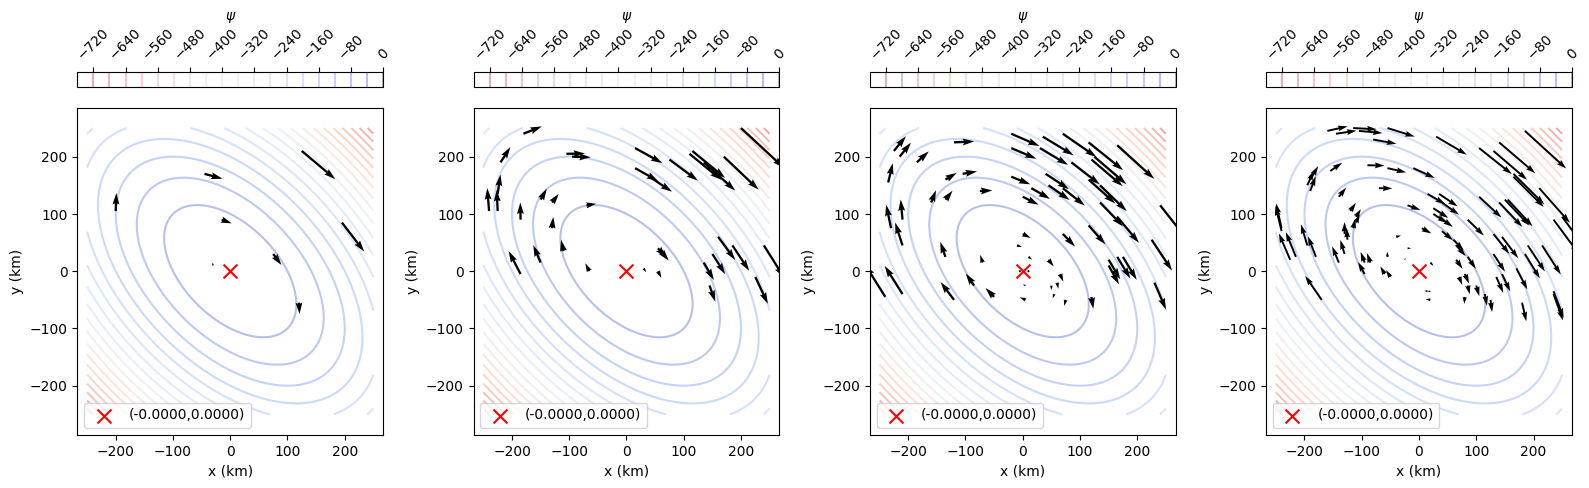

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for k, ax in enumerate(axs):
    random_indices = np.random.choice(u_ell.shape[0] * u_ell.shape[1], size=20*(2*k+1), replace=False)
    print(20*(2*k+1))

    random_indices = random_indices[random_indices > 4000] # restriction

    row_indices, col_indices = np.unravel_index(random_indices, u_ell.shape)

    ui = u_ell.T[row_indices, col_indices]
    vi = v_ell.T[row_indices, col_indices]
    xi = X_ell[row_indices, col_indices]
    yi = Y_ell[row_indices, col_indices]

    # cs = np.hypot(u_ell, v_ell)
    c = ax.contour(x_ell, y_ell, Psi_ell.T, cmap='coolwarm_r', levels=20, zorder=-1, alpha=.4)

    # ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k', scale=20)

    x0, y0, q11, q12, q22, w = VGspace(xi, yi, ui, vi)
    print(f"x0: {x0}, y0: {y0}")

    sca = ax.scatter(x0, y0, color='r', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label=r'$\psi$')
    cbar.ax.tick_params(axis='x', labelrotation=45)

    ax.legend([sca], [f'({x0:.4f},{y0:.4f})'], loc='lower left')

plt.tight_layout()
plt.show()



## Modelled Eddy



In [6]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]


x0: 28.176107, y0: 2.205846
x0: -1.635413, y0: -25.854073
x0: -17.852335, y0: 25.903700
x0: 23.604084, y0: -1.359790


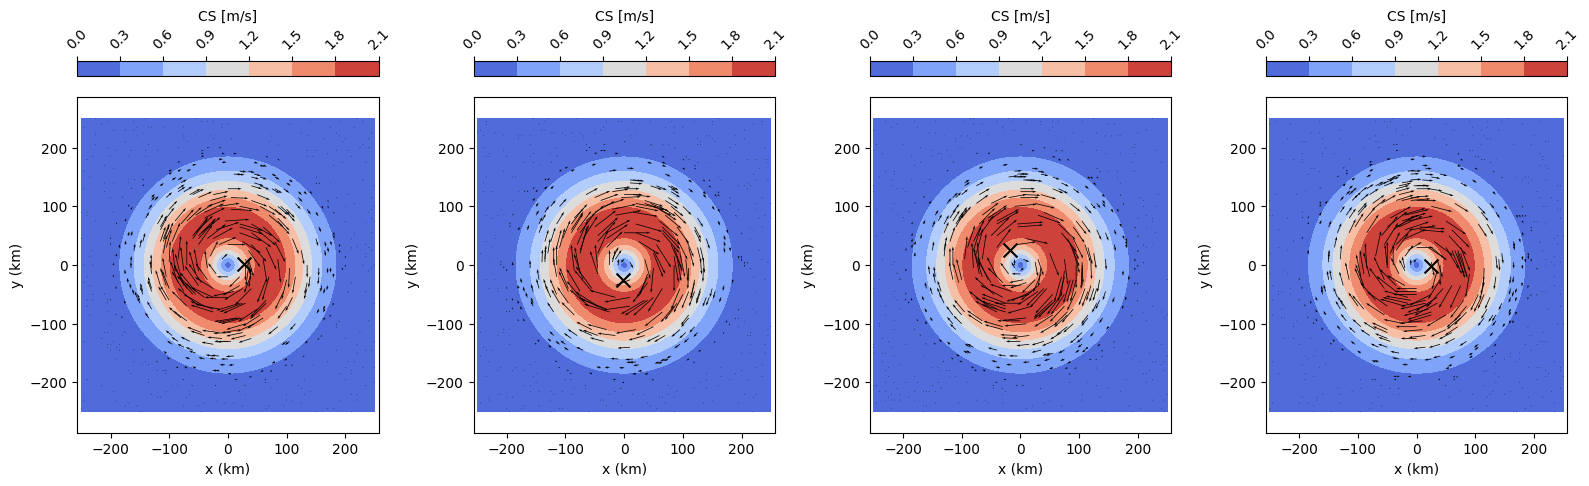

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for ax in axs:
    random_indices = np.random.choice(u_ell.shape[0] * u_ell.shape[1], size=600, replace=False)

    row_indices, col_indices = np.unravel_index(random_indices, u_ell.shape)

    ui = u.T[row_indices, col_indices]
    vi = v.T[row_indices, col_indices]
    xi = X[row_indices, col_indices]
    yi = Y[row_indices, col_indices]

    cs = np.hypot(u, v)
    c = ax.contourf(x_ell, y_ell, cs.T, cmap='coolwarm')

    # ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22, w = VGspace(xi, yi, ui, vi)
    print(f"x0: {x0:2f}, y0: {y0:2f}")

    ax.scatter(x0, y0, color='k', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')


    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label='CS [m/s]')
    cbar.ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

x0: -0.000000, y0: 0.000000
x0: -0.000000, y0: 0.000000
x0: -0.000000, y0: 0.000000
x0: -0.000000, y0: 0.000000


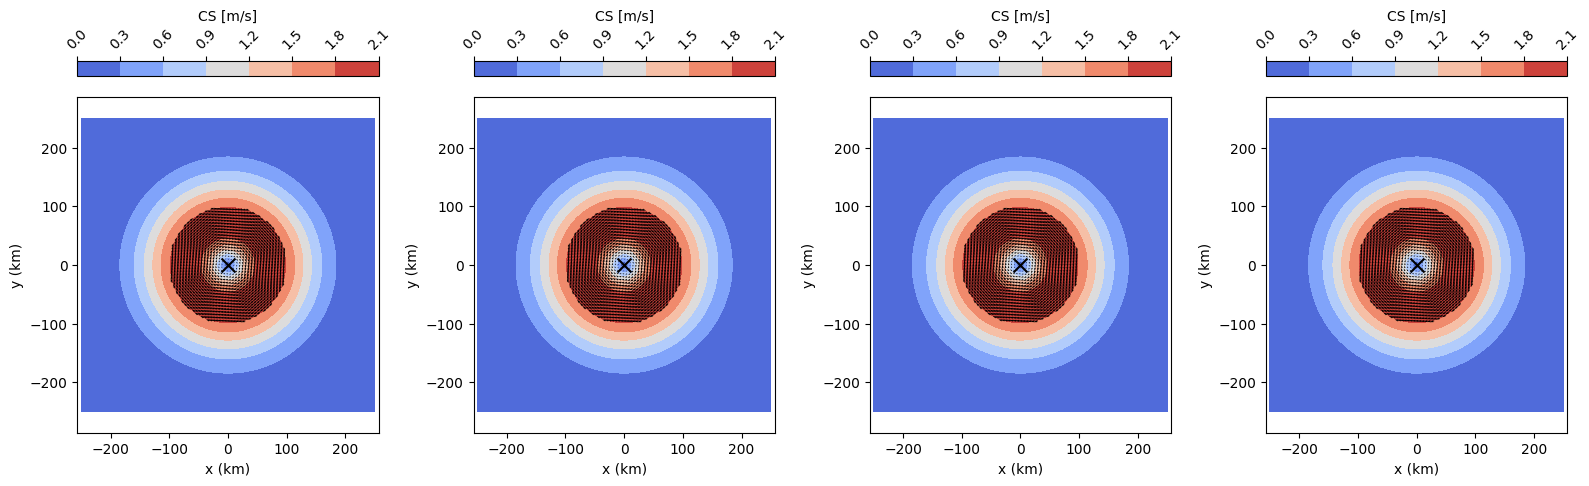

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for ax in axs:
    
    x_search, y_search = 0, 0
    mask = np.hypot(X - x_search, Y - y_search) < 100
    # valid_indices = np.argwhere(mask == 1)  # Get row, col indices of valid points

    # selected_indices = valid_indices[np.random.choice(valid_indices.shape[0], size=20, replace=False)]

    # row_indices, col_indices = selected_indices[:, 0], selected_indices[:, 1]

    row_indices, col_indices = np.where(mask)

    ui = u.T[row_indices, col_indices]
    vi = v.T[row_indices, col_indices]
    xi = X[row_indices, col_indices]
    yi = Y[row_indices, col_indices]

    cs = np.hypot(u, v)
    c = ax.contourf(x_ell, y_ell, cs.T, cmap='coolwarm')

    # ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22, w = VGspace(xi, yi, ui, vi)
    print(f"x0: {x0:2f}, y0: {y0:2f}")

    ax.scatter(x0, y0, color='k', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')


    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label='CS [m/s]')
    cbar.ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

# Elliptical Vortex

In [13]:
u, v, x, y = calculate_eddy(q11=2, q22=2, q12=1)
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

In [14]:
%%capture

df_error = pd.DataFrame(columns=['Boundary', 'i', 'j', 'r', 'xc', 'yc', 'Error'])

for boundary in [35, 40, 45]:
    for i in range(boundary, u.shape[0] - boundary, 2):
        for j in range(boundary, u.shape[1] - boundary, 2):
    
            for r_rel in [2, 5, 10, 20]:

                mask = (np.hypot(X - X[i, j], Y - Y[i, j]) < r_rel).T
                xi, yi = X[mask], Y[mask]
                ui, vi = u.T[mask], v.T[mask]
                
                x0_rel, y0_rel, _, _, _, _ = VGspace(xi, yi, ui, vi)

                err = np.hypot(x0_rel, y0_rel)
        
                df_error.loc[len(df_error)] = {'Boundary': boundary, 'i': i, 'j': j, 'r': r_rel, 'xc': x0_rel, 'yc': y0_rel, 'Error': err}
            

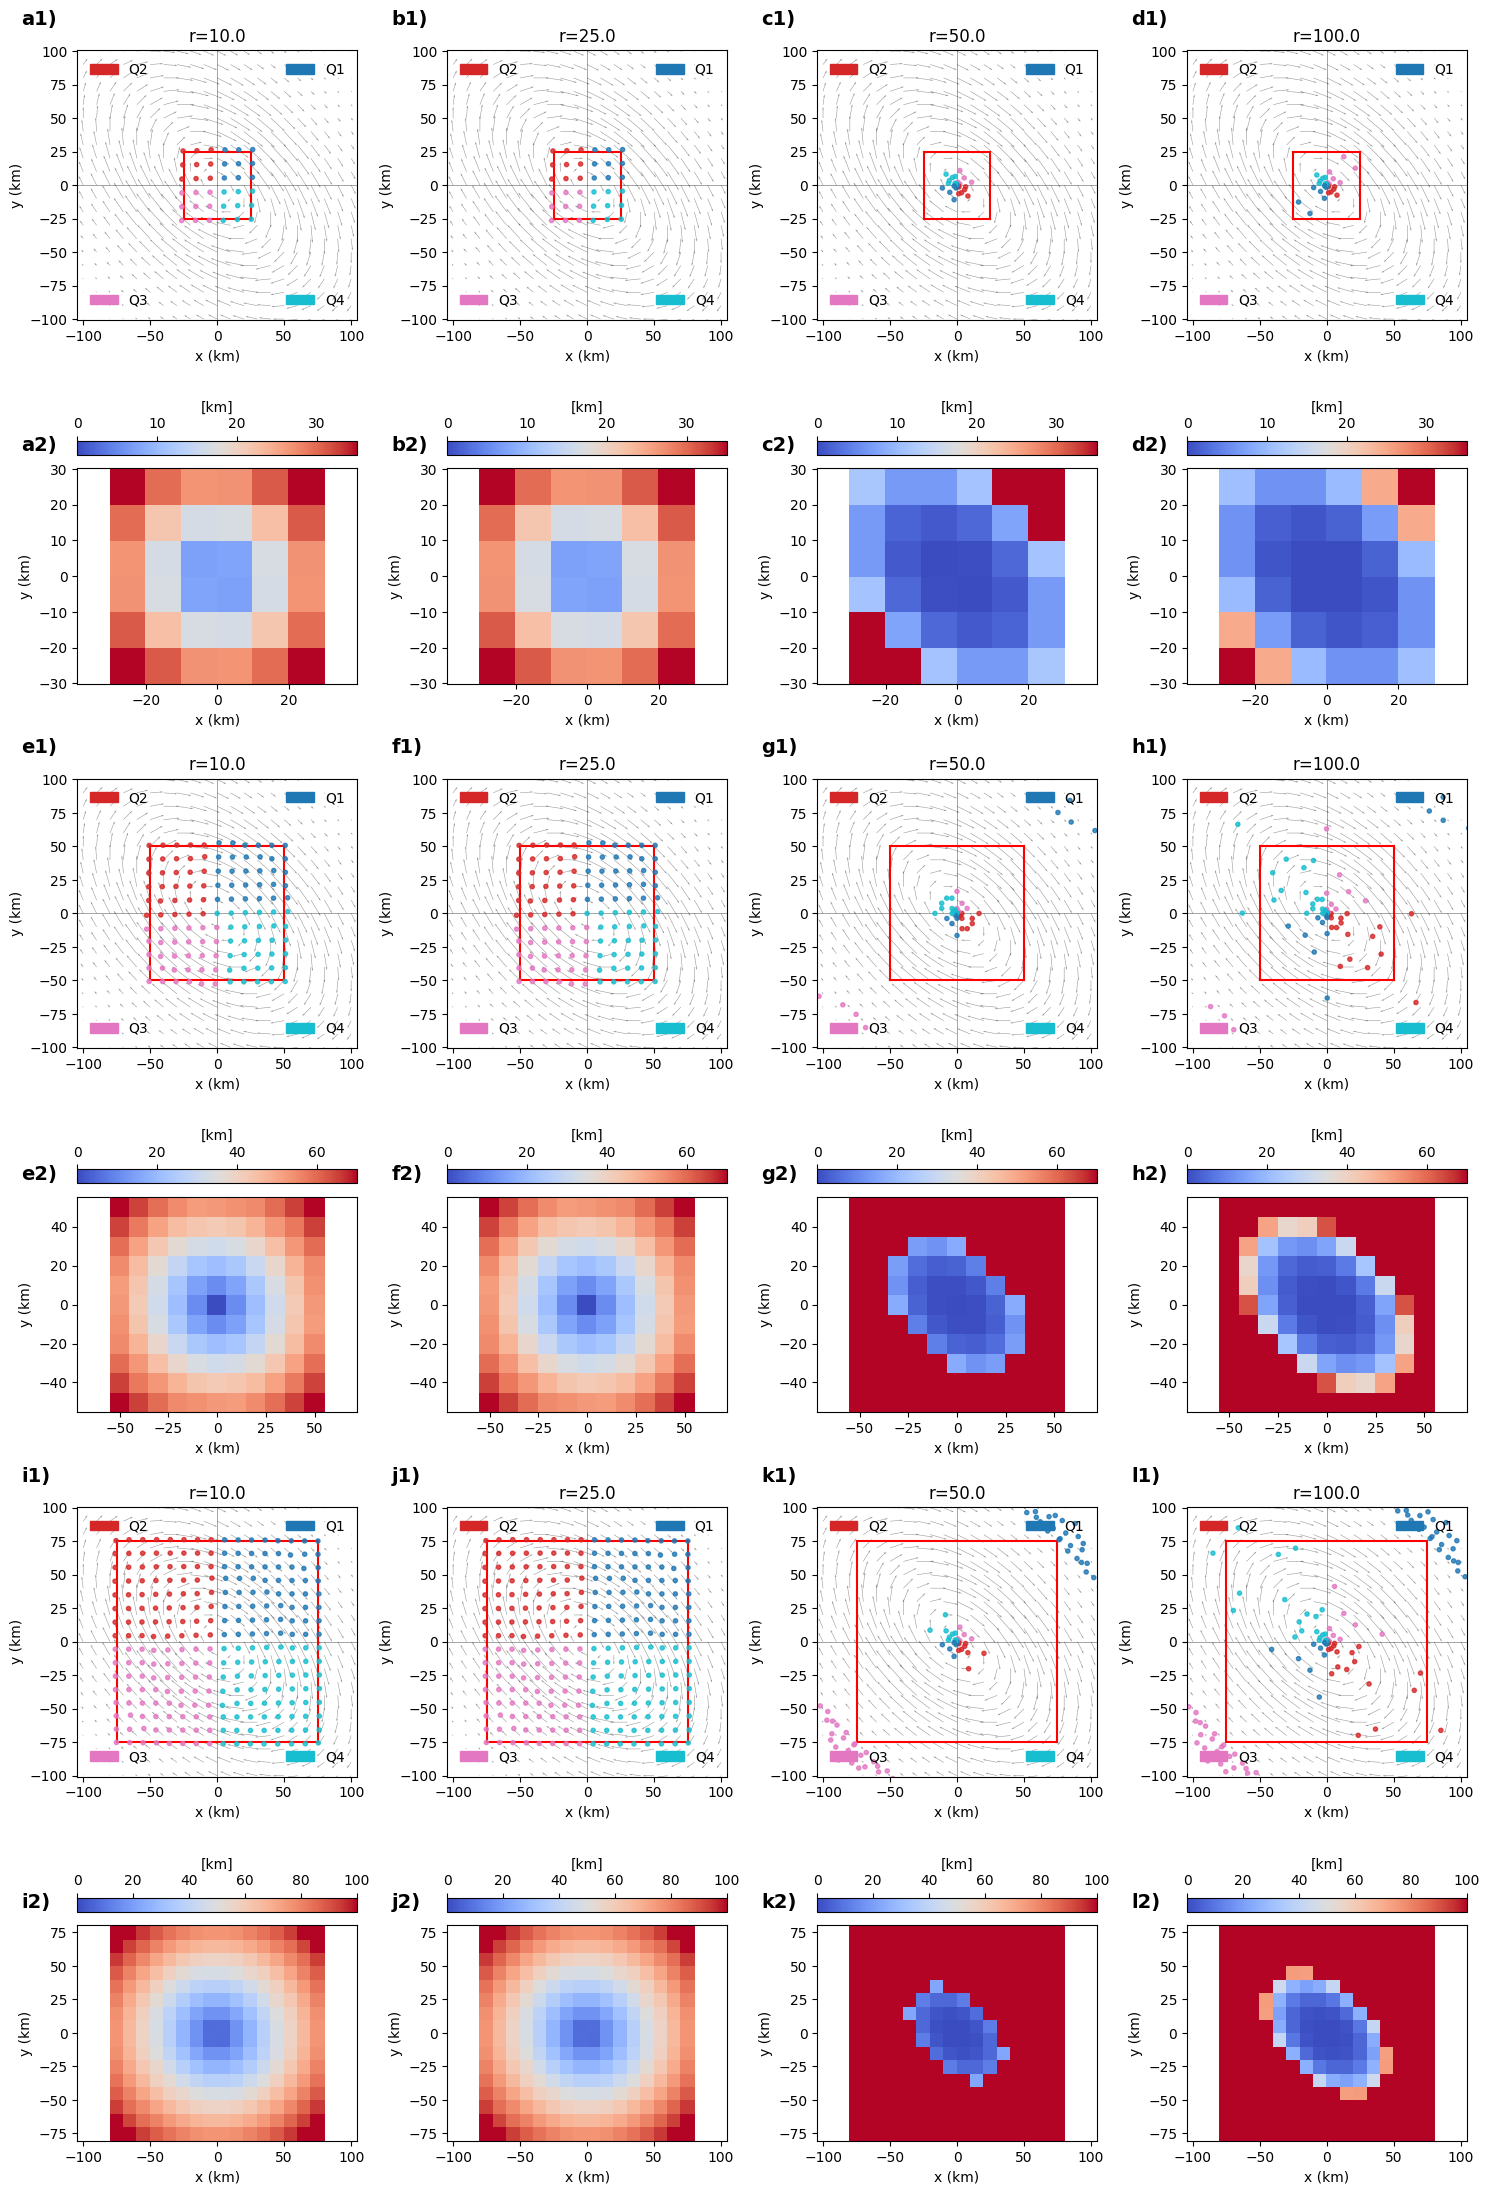

In [15]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(6, 4, figsize=(15,22))

tgs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

spacing, scale, width = 2, 40, 0.002

vmaxs = [35, 70, 100]
for i, r_check in enumerate([2, 5, 10, 20]):

    for j, boundary in enumerate(np.flip(df_error['Boundary'].unique())):    
    
        axs[2*j,i].quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
                   alpha=0.4, scale=scale, width=width, zorder=0)
    
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[u.shape[1] - boundary - 1], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[boundary], y[boundary]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[boundary]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[u.shape[0] - boundary - 1], x[u.shape[0] - boundary - 1]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        
        df_rel = df_error.loc[(df_error['r'] == r_check) & (df_error['Boundary'] == boundary)].copy()
    
        def get_quadrant(i, j, center):
            if i >= center[0] and j > center[1]:
                return 1  # Top-right
            elif i < center[0] and j >= center[1]:
                return 2  # Top-left
            elif i <= center[0] and j < center[1]:
                return 3  # Bottom-left
            else:
                return 4  # Bottom-right
        
        df_rel['Q'] = df_rel.apply(lambda row: get_quadrant(row['i'], row['j'], (u.shape[0]//2, v.shape[1]//2)), axis=1)
    
        # Define legend locations
        legend_locs = {1: 'upper right', 2: 'upper left', 3: 'lower left', 4: 'lower right'}
        scatter = axs[2*j, i].scatter(df_rel['xc'], df_rel['yc'], c=df_rel['Q'], marker='.', zorder=2, cmap='tab10', alpha=.8)
        unique_q = np.append(df_rel['Q'].unique(),0)
        for q in unique_q:
            if q in legend_locs:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc=legend_locs[q], frameon=False)
                axs[2*j, i].add_artist(legend)  # Keep adding legends instead of replacing
            else:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc='upper center', frameon=False)
                legend.set_visible(False)

        axs[2*j,i].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        axs[2*j,i].axvline(x=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        
        axs[2*j,i].axis('equal')
        axs[2*j,i].set_xlim(-100, 100)
        axs[2*j,i].set_ylim(-100, 100)
        axs[2*j,i].set_title(f'r={r_check*dx}')
        axs[2*j,i].set_xlabel('x (km)')
        axs[2*j,i].set_ylabel('y (km)')

        axs[2*j,i].text(-0.2, 1.15, tgs[4*j+i]+'1)', transform=axs[2*j,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
        # plot2
        
        x_unique = np.unique(x[df_rel['i']])
        y_unique = np.unique(y[df_rel['j']])
        
        z_2d = np.full((len(y_unique), len(x_unique)), np.nan)
        
        # Fill the 2D z array with the corresponding z values
        for xi, yi, zi in zip(x[df_rel['i']], y[df_rel['j']], df_rel['Error']):
            x_idx = np.where(x_unique == xi)[0][0]
            y_idx = np.where(y_unique == yi)[0][0]
            z_2d[y_idx, x_idx] = zi
        
        pcl = axs[2*j+1,i].pcolor(x_unique, y_unique, z_2d, vmin=0, vmax=vmaxs[j], cmap='coolwarm')
        cbar = plt.colorbar(pcl, ax=axs[2*j+1, i], orientation='horizontal', location='top', label='[km]')
        axs[2*j+1,i].axis('equal')
    
        axs[2*j+1,i].set_xlabel('x (km)')
        axs[2*j+1,i].set_ylabel('y (km)')

        axs[2*j+1,i].text(-0.2, 1.15, tgs[4*j+i]+'2)', transform=axs[2*j+1,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
plt.tight_layout()
plt.show()

### Error Map

In [17]:
# X, Y = np.meshgrid(x, y)
# df_r_tests = pd.DataFrame(columns=['i', 'j', 'x0', 'y0', 'Err', 'r'])
# boundary = 20

# for nic_rel in range(boundary, u.shape[0] - boundary):
#     for njc_rel in range(boundary, u.shape[1] - boundary):

#         df = pd.DataFrame(columns=['i', 'j', 'x0', 'y0', 'w', 'Err', 'r'])
#         for r_rel in range(2, 11):
            
#             mask = (np.hypot(X - X[nic_rel, njc_rel], Y - Y[nic_rel, njc_rel]) < r_rel).T
#             xi, yi = X[mask], Y[mask]
#             ui, vi = u.T[mask], v.T[mask]

#             x0_rel, y0_rel, *_ = VGspace(xi, yi, ui, vi)
            
#             error_rel = np.hypot(x0_rel, y0_rel)
#             df.loc[len(df)] = {'i': nic_rel, 'j': njc_rel, 'x0': x0_rel, 'y0': y0_rel, 
#                                 'Err': error_rel, 'r': r_rel}

#         # if not df.empty:
#         df_r_tests.loc[len(df_r_tests)] = df.loc[df['Err'].idxmin()]

# df_r_tests

,i,j,x0,y0,Err,r
0,20.0,20.0,-150.000016,-150.000016,212.132056,2.0
1,20.0,21.0,-150.000023,-145.000023,208.626493,2.0
2,20.0,22.0,-150.000036,-140.000035,205.182896,2.0
3,20.0,23.0,-150.000054,-135.000052,201.804436,2.0
4,20.0,24.0,-150.000081,-130.000077,198.494445,2.0
...,...,...,...,...,...,...
3716,80.0,76.0,150.000081,130.000077,198.494445,2.0
3717,80.0,77.0,150.000054,135.000052,201.804436,2.0
3718,80.0,78.0,150.000036,140.000035,205.182896,2.0
3719,80.0,79.0,150.000023,145.000023,208.626493,2.0


In [39]:
# df_r_tests.to_csv("Error_Data/VGspace_df.csv", index=True) 

### ROMS

In [ ]:
break

In [ ]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

In [ ]:
df_MOCA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]

            mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
            xi, yi = X_roms[mask], Y_roms[mask]
            ui, vi = u_roms.T[mask], v_roms.T[mask]

            xc, yc, q11, q12, q22, w = VGspace(xi, yi, ui, vi)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_MOCA.loc[len(df_MOCA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x - xc).argmin()
                    njc = np.abs(y - yc).argmin()
                    
                else:
                    break
            else:
                break

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t)]
        axs[i].plot(df['xc'], -df['Depth'])
        
    axs[i].set_title(f'Eddy {i+1}')
    
    axs[i].set_xlabel('x (km)')
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()


### Plotting

In [ ]:
eddy1 = [the_frontier_eddies[0]] * 3 
t1 = [0, 5, 15, 25, 29]
z1 = [3, 0, 3, 20, 0]

eddy2 = [the_frontier_eddies[1]] * 9
t2 = [0, 10, 10, 10, 10, 20, 29]
z2 = [20, 3, 15, 20, 5, 5, 20]

eddy3 = [the_frontier_eddies[2]] * 14
t3 = [0, 5, 10, 10, 15, 15, 15, 25, 25, 25, 25, 25, 29, 29]
z3 = [5, 0, 5, 15, 0, 3, 9, 0, 3, 9, 15, 20, 15, 20]

eddy4 = [the_frontier_eddies[3]] * 10
t4 = [0, 0, 0, 5, 10, 10, 15, 20, 20, 29]
z4 = [5, 8, 20, 20, 3, 20, 20, 8, 20, 20]

df_show_offs = pd.DataFrame({
    'Eddy': eddy1 + eddy2 + eddy3 + eddy4,
    'Day': t1 + t2 + t3 + t4,
    'z': z1 + z2 + z3 + z4
    })


In [ ]:
from scipy.spatial import ConvexHull

rows, cols = 6, 6

fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharey=True, sharex=True)

for k in range(len(df_show_offs)):

    ax = axs[k % rows, k//rows]

    df_rel = df_show_offs.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
    points = np.column_stack((X_roms[mask], Y_roms[mask]))
    
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='b', alpha=0.3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
def plotter(eddy, t, depth_lvl):
    fig = plt.figure(figsize=(4,4))
    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
    
    spacing = 5
    plt.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
    points = np.column_stack((X_roms[mask], Y_roms[mask]))
    
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='b', alpha=0.3)
    
    plt.scatter(xc, yc, marker='x', s=100, color='r')

    plt.title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')


In [ ]:
# for eddy in the_frontier_eddies:
#     for t in [0, 5, 10, 15, 20, 25, 29]:
#         for depth_lvl in [0, 3, 5, 8, 9, 15, 20]:

#             plotter(eddy, t, depth_lvl)

## RV Investigator


In [ ]:
# file_path = "your_file.mat"
# data = loadmat(file_path)

# # Convert specific variables to CSV
# for key in data:
#     if not key.startswith("__"):
#         df = pd.DataFrame(data[key])
#         df.to_csv(f"{key}.csv", index=False)

In [ ]:
lat_RV = pd.read_csv("IN2017_V04/lat_sadcp.csv")
lat = np.array(lat_RV.iloc[:, 0])
lon_RV = pd.read_csv("IN2017_V04/lon_sadcp.csv")
lon = np.array(lon_RV.iloc[:, 0])
tim_RV = pd.read_csv("IN2017_V04/tim_sadcp.csv")
tim = np.array(tim_RV.iloc[:, 0])
u_RV = pd.read_csv("IN2017_V04/u_sadcp.csv")
v_RV = pd.read_csv("IN2017_V04/v_sadcp.csv")
z_RV = pd.read_csv("IN2017_V04/z_sadcp.csv")
z = np.array(z_RV.iloc[:, 0])

u_RV = u_RV.set_index(pd.Index(z, name="Depth"))
v_RV = v_RV.set_index(pd.Index(z, name="Depth"))

depth = 47
u, v = u_RV.loc[depth], v_RV.loc[depth]

df_RV = pd.DataFrame({'Lon': lon, 'Lat': lat, 'u': u, 'v': v, 't': tim})
df_RV = df_RV.dropna()

df_RV['t'] = df_RV['t']-df_RV['t'].iloc[0]

In [ ]:
df_RV

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9))

# Plot 1
sc = axs[0,0].scatter(df_RV['Lon'], df_RV['Lat'], c=df_RV['t'], cmap='viridis')
axs[0,0].plot(df_RV['Lon'], df_RV['Lat'], color='k', alpha=0.5)
fig.colorbar(sc, ax=axs[0,0], label='Day')

# Plot 2
# t1_1, t2_1 = 7.5, 13
t1_1, t2_1 = 9.2, 12
t1_2, t2_2 = 14, 19
t1_3, t2_3 = 3, 7

c = np.array(['k'] * len(df_RV))
c[(df_RV['t'] > t1_1) & (df_RV['t'] < t2_1)] = ['b']
c[(df_RV['t'] > t1_2) & (df_RV['t'] < t2_2)] = ['m']
c[(df_RV['t'] > t1_3) & (df_RV['t'] < t2_3)] = ['g']

axs[0,1].quiver(df_RV['Lon'], df_RV['Lat'], df_RV['u'], df_RV['v'], color=c, alpha=0.5)

xc1, yc1 = rv_plotter(t1_1, t2_1, ax=axs[1,0], c='b')
xc2, yc2 = rv_plotter(t1_2, t2_2, ax=axs[1,1], c='m')
xc3, yc3 = rv_plotter(t1_3, t2_3, ax=axs[1,2], c='g')

axs[0,1].scatter([xc1, xc2, xc3], [yc1, yc2, yc3], marker = 'x', color=['b', 'm', 'g'])

for ax in axs.flat:
    ax.axis('equal')

xmin, xmax = np.min([axs[0,0].get_xlim()[0], axs[0,1].get_xlim()[0]]), np.max([axs[0,0].get_xlim()[1], axs[0,1].get_xlim()[1]])
ymin, ymax = np.min([axs[0,0].get_ylim()[0], axs[0,1].get_ylim()[0]]), np.max([axs[0,0].get_ylim()[1], axs[0,1].get_ylim()[1]])

axs[0,0].set_xlim(xmin, xmax)
axs[0,0].set_ylim(ymin, ymax)
axs[0,1].set_xlim(xmin, xmax)
axs[0,1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [ ]:
def rv_plotter(t1, t2, ax=None, c='k'):
    df = df_RV[(df_RV['t'] > t1) & (df_RV['t'] < t2)]
    xi, yi = np.array(df['Lon']), np.array(df['Lat'])
    ui, vi = np.array(df['u']), np.array(df['v'])
    
    if ax is None:
        fig, ax = plt.subplots()  # Create a new figure and axis if not provided
    
    ax.quiver(xi, yi, ui, vi, width=None, zorder=3, color=c)
    xc, yc, q11, q12, q22, w = VGspace(xi, yi, ui, vi)
    ax.scatter(xc, yc, zorder=4, marker='x', color='k')
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    det = q11 * q22 - q12 ** 2
    print(det)
    
    x_e = np.linspace(xlims[0], xlims[1], 101)  
    y_e = np.linspace(ylims[0], ylims[1], 101) 
    X_e, Y_e = np.meshgrid(x_e, y_e)
    
    Q = np.array([[q11, q12], [q12, q22]])
    XY = np.stack((X_e - xc, Y_e - yc), axis=-1)  
    Psi_e = np.einsum("...i,ij,...j->...", XY, Q, XY)
    u_e = (-2 * q22 * (Y_e - yc) - 2 * q12 * (X_e - xc)).T
    v_e = (2 * q11 * (X_e - xc) + 2 * q12 * (Y_e - yc)).T
    
    ax.contour(X_e, Y_e, Psi_e, 20, alpha=.6)
    
    if ax is None:
        plt.show()  # Display the figure if one was created
    return xc, yc

In [ ]:
xc, yc = rv_plotter(t1_1, t2_1)


In [ ]:
xc, yc = rv_plotter(t1_2, t2_2)


In [ ]:
xc, yc = rv_plotter(t1_3, t2_3)


In [ ]:
# import netCDF4 as nc

# df_tim = pd.DataFrame(columns=['sshT', 'rvT'])
# for day in range(22):

#     fname = f'/srv/scratch/z5297792/marina_observational_data/IN23_SSH/IMOS_OceanCurrent_HV_202310{day+6:02d}T180000Z_GSLA_FV02_NRT.nc'
    
#     dataset = nc.Dataset(fname)
#     ot = dataset.variables['TIME'][:].data + 2446161.5
#     df_tim.loc[len(df_tim)] = {'sshT': ot[0], 'rvT': tim[day]}